# pyDynMelt

A Jupyter notebook that calculates uranium-series disequilibrium during melting with disequilibrium chemical transport, i.e. dynamic melting, after McKenzie (1985) and using formulations developed in Spiegelman and Elliott (1993) and methods similar to those of Spiegelman (2000) for the UserCalc equilibrium transport model.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
# set initial inputs here

# set input name of this model run (should match input file name, without file extension)
runname='sample'

# set lithosphere (final melting) pressure
Plithos = 5.0  # kilobars

## Some plotting utilities

In [12]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth']=2
mpl.rcParams['font.size']=16
## Some utility functions for plotting

def plot_inputs(df,figsize=(8,6)):
    ''' 
        pretty plots input data from pandas dataframe df
    '''
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True,figsize=figsize)
    ax1.plot(df['F'],df['P'])
    ax1.invert_yaxis()
    ax1.set_xlabel('F')
    ax1.set_ylabel('Pressure (kb)')
    xticks = np.linspace(0,max(df['F']),10)
    ax1.grid()
    ax1.set_xticks(xticks,minor=True)
    ax2.plot(df['Kr'],df['P'])
    ax2.set_xlabel('Kr')
    for s in ['DU','DTh','DRa','DPa']:
        ax3.semilogx(df[s],df['P'],label=s)
    ax3.set_xlabel('Ds')
    ax3.legend(loc='best',bbox_to_anchor=(1.1,1))
    
def plot_1Dcolumn(df,figsize=(8,6)):
    '''
        pretty plots output data from dataframe of output
    '''
    
    fig, (ax1, ax2) = plt.subplots(1,2, sharey=True,figsize=figsize)
    ax1.plot(df['phi'],df['P'],'r',label='$\phi$')
    ax1.set_xlabel('Porosity',color='r')
    ax1.set_ylabel('Pressure (kb)')
    ax1.invert_yaxis()

    ax1a = ax1.twiny()
    ax1a.plot(df['F'],df['P'],'b',label='$F$')
    ax1a.set_xlabel('Degree of melting',color='b')

    for s in ['(230Th/238U)','(226Ra/230Th)','(231Pa/235U)']:
        ax2.plot(df[s],df['P'],label=s)
    ax2.set_xlabel('Activity Ratios')
    ax2.set_xlim(0,5)
    ax2.set_xticks(range(5))
    ax2.grid()
    ax2.legend(loc='best',bbox_to_anchor=(1.1,1))
    return fig,(ax1,ax1a,ax2)

def plot_mesh_Ra(Th,Ra,figsize=(8,8)):
    '''
    activity mesh plot for Ra vs. Th, from gridded data
    '''    
    mW,nphi=Th.shape    
    plt.figure()
    for m in range(mW):
        plt.plot(Th[m],Ra[m],label='W = {} cm/yr'.format(W0[m]))
    for n in range(nphi):
        plt.plot(Th.T[n],Ra.T[n],label='$\phi$ = {}'.format(phi0[n]))

    plt.legend(loc='best',bbox_to_anchor=(1.1,1))
    plt.axis([0.9,1.5,0.7,4.0])
    plt.xlabel('($^{230}$Th/$^{238}$U)')
    plt.ylabel('($^{226}$Ra/$^{230}$Th)')
#    plt.axes().set_aspect('equal',)

    plt.savefig("{}_Ra-Th.ps".format(runname))

def plot_mesh_Pa(Th,Pa,figsize=(8,8)):
    '''
    activity mesh plot for Pa vs. Th, from gridded data
    '''
    mW,nphi = Th.shape
    plt.figure()
    for m in range(mW):
        plt.plot(Th[m],Pa[m],label='W = {} cm/yr'.format(W0[m]))
    for n in range(nphi):
        plt.plot(Th.T[n],Pa.T[n],label='$\phi$ = {}'.format(phi0[n]))

#    plt.legend(loc='best',bbox_to_anchor=(1.1,1))
    plt.axis([0.9,1.5,0.7,4.0])
    plt.xlabel('($^{230}$Th/$^{238}$U)')
    plt.ylabel('($^{226}$Ra/$^{230}$Th)')
    
    plt.savefig("{}_Pa-Th.ps".format(runname))
    
    plt.show()


## A generic disequilibrium decay chain solver class

This class solves the radiocative decay chain problem for the logarithm of the melt concentration, after Equation 9 in Spiegelman (2000):

$$
    \frac{dU_i}{dz} = \frac{1}{c_i} \frac{dc_i}{dz}
$$

and

$$
  U_i = U^s_i + U^r_i
$$


In [13]:
from scipy.integrate import solve_ivp

class DecayChain:
    '''
    A class for calculating radioactive decay chains with disequilibrium transport
    
    Usage:  solver=DecayChain(alpha0,D0,lambdas,rho_s,rho_f,phi0,W0,F,zp)
    
    inputs:
        alpha0  :  numpy array of initial activities
        D0      :  numpy array of initial partition coefficients
        lambdas :  decay constants
        rho_s: solid density
        rho_f: fluid density
        phi0: porosity
        W0: solid upwelling rate
        F: vector of degree of melting with zp
        zp: rescaled z increments
        
    Outputs:  pandas DataFrame with columns z, U, U_s, U_r
    '''
    
    def __init__(self,alpha0,D0,lambdas,rho_s,rho_f,phi0,W0,F,zp):
        self.alpha0 = alpha0
        self.D0 = D0
        self.lambdas = lambdas
        self.rho_s = rho_s
        self.rho_f = rho_f
        self.phi0 = phi0
        self.W0 = W0
        self.F = F
        self.zp = zp
        
    def rhs(self,z,Us,Uf):
        '''
        Returns right hand side of generic decay chain problem for the log of the concentrations.
        
        Total Solid:
        DUsdz = (1-1/D_i)/(1-F) * dFdz + [(1.-phi0)*lam_i)/(W0*(1-F))] * [lam_{i-1}/lam_i * exp(U_sol_{i-1} - U_sol_i) - 1.)]
        
        Total melt:
        DUfdz = (c_s^i/D_i-c_f^i)/F * dFdz + [(rho_f*phi0*lam_i)/(rho_s*W0*F)] * [lam_{i-1}/lam_i * exp(U_f_{i-1} - U_f_i) - 1.)]
        '''
        
        # initial values
        D0 = self.D0
        lambdas = self.lambdas
        rho_f = self.rho_f
        rho_s = self.rho_s
        phi0 = self.phi0
        W0 = self.W0
        F = self.F
        dz = np.mean(np.diff(zp))
        dFdz = np.gradient(F,dz)

        # factors and combined variables
        expU_s = np.zeros(len(D0))
        expU_f = np.zeros(len(D0))
        R_s = np.zeros(len(D0))
        R_f = np.zeros(len(D0))
        c_s = np.zeros(len(D0))
        c_f = np.zeros(len(D0))
        lam_ratio = np.zeros(len(D0))
        
        for i in range(1,len(lambdas)):
            R_s[i] = [(1.-phi0)*lambdas/(W0*(1-F))]
            R_f[i] = [(rho_f*phi0*lambdas)/(rho_s*W0*F)]
            expU_s[i] = np.exp(U_s[i-1]-U_s[i])
            expU_f[i] = np.exp(U_f[i-1]-U_f[i])
            c_s[i] = alpha0[i]*np.exp(U_s[i])
            c_f[i] = alpha0[i]*np.exp(U_f[i])
            lam_ratio[i] = lambdas[i-1]/lambdas[i]
        # return full RHS for both solid and melt
        
        return (1-1/D)/(1-F)*dFdz + R_s*(lam_ratio*expU-1.), (c_s/D-c_f)/F*dFdz + R_f*(lam_ratio*expU-1.)
        
    def solve(self,z_eval=None):
        '''
        solves generic radioactive decay chain problem as an ODE initial value problem
        if z_eval = None,  save every point
        else save output at every z_eval depth
        '''
        
        # Set initial condition and solve ODE      
        Uall_0 = np.zeros(len(self.D0),2)
        
        sol = solve_ivp(self.rhs,(0.,1.),Uall_0,t_eval=z_eval,method='RK45')
        z = sol.t
        Uall = sol.y
        
        return z,Uall
        
        

## The main DynMelt class

This class takes in a dataframe of inputs, initializes the appropriate splines and porosity functions
then presents a set of methods for calculating 1D columns and grid figures.

In [14]:
from scipy.optimize import brentq
from scipy.interpolate import interp1d, pchip


class DynMelt:
    ''' A class for constructing solutions for disequilibrium transport U-series calculations
        
        Usage: 
        us = DynMelt(df,dPdz = 0.32373, n = 2., tol=1.e-6, phi0 = 0.01, W0 = 3.) 
        
        with 
        df   :  a pandas-dataframe with columns ['P','Kr','DU','DTh','DRa','DPa']
        dPdz :  Pressure gradient to convert P to z
        n    :  permeability exponent
        tol  :  tolerance for ODE solver
        phi0 :  initial porosity
        W0   : upwelling velocity (cm/yr)
        
        Methods:
            
    '''
    def __init__(self, df, dPdz = 0.32373, n = 2., tol = 1.e-6, phi0 = 0.01, W0 = 3.):
        self.df = df
        self.dPdz = dPdz
        self.n = n
        self.tol = 1.e-6
        self.phi0 = phi0
        self.W0 = W0/1.e5
        
        # set depth scale h
        self.zmin = df['P'].min()/dPdz
        self.zmax = df['P'].max()/dPdz
        self.h = self.zmax - self.zmin
        
        # lambda function to define scaled column height zprime
        self.zp = lambda P: (self.zmax - P/dPdz)/self.h
        
        # set interpolants for F and Kr and pressure
        self.F = pchip(self.zp(df['P']),df['F'])
        self.Kr = interp1d(self.zp(df['P']),df['Kr'],kind='cubic')
        self.P = interp1d(self.zp(df['P']),df['P'],kind='cubic')

        # set maximum degree of melting
        self.Fmax = self.df['F'].max()
        
        # set reference densities (assuming a mantle composition)
        self.rho_s = 3300.
        self.rho_f = 2800.
        
        # set  decay constants for [ 238U, 230Th, 226Ra] and [ 235U, 231Pa ]       
        t_half_238 = np.array([4.468e9, 7.54e4, 1600.])
        t_half_235 = np.array([7.03e8, 3.276e4])
        self.lambdas_238 = np.log(2.)/t_half_238
        self.lambdas_235 = np.log(2.)/t_half_235
        
        # set interpolation functions for Partition coefficients for each chain
        self.D_238 = [ interp1d(self.zp(df['P']),df['DU'],kind='cubic'),
                       interp1d(self.zp(df['P']),df['DTh'],kind='cubic'),
                       interp1d(self.zp(df['P']),df['DRa'],kind='cubic') ]
        self.D_235 = [ interp1d(self.zp(df['P']),df['DU'],kind='cubic'),
                       interp1d(self.zp(df['P']),df['DPa'],kind='cubic')]
        
        # lambda function to get partition coefficients at zprime = 0
        self.get_D0 = lambda D: np.array([ D[i](0) for i in range(len(D))])
                        
        # initialize reference permeability
        self.setAd(self.phi0,n=n)
        
        # initialize porosity function
        
    def setAd(self,phi0,n):
        ''' 
            sets the reference permeability given the maximum porosity 
        '''
        Fmax = self.Fmax
        self.phi0 = phi0
        self.n = n
        self.Ad =  (self.rho_s/self.rho_f*Fmax - phi0*(1. - Fmax)/(1. - phi0))/(phi0**n*(1.-phi0))
        
    def phi(self,zp):
        '''
        returns porosity as function of dimensionless column height zp
        '''
        # effective permeability
        K = self.Kr(zp)*self.Ad
        
        # degree of melting
        F = self.F(zp)
        
        # density ratio
        rs_rf = self.rho_s/self.rho_f
        
        # rootfinding function to define porosity such that f(phi) = 0
        
        # check if scalar else loop
        if np.isscalar(zp):
            f = lambda phi: K*phi**self.n*(1. - phi)**2 + phi*(1. + F*(rs_rf - 1.)) - F*rs_rf
            upper_bracket= 1.05*self.phi0
            try:
                phi = brentq(f,0.,upper_bracket)
            except ValueError:
                phi_test = np.linspace(0,upper_bracket)
                print('Error in brentq: brackets={}, {}'.format(f(0.),f(upper_bracket)))
                print('zp={},F={}, K={}'.format(zp,F,K))                    
        else: # loop over lenght of zp
            phi = np.zeros(zp.shape)
            for i,z in enumerate(zp):
                f = lambda phi: K[i]*phi**self.n*(1. - phi)**2 + phi*(1. + F[i]*(rs_rf - 1.)) - F[i]*rs_rf
                phi[i] = brentq(f,0.,1.)
        return phi
    
    def set_column_params(self, phi0, n, W0,F):
        '''
        set porosity/permeability and upwelling rate parameters for a single column
        
        phi0: porosity at Fmax
        n   : permeability exponent
        W0  : upwelling rate (cm/yr)
        '''
    
        self.setAd(phi0,n)
        self.W0 = W0/1.e5 # upwelling in Km/yr
        
    def solve_1D(self,D,lambdas,alpha0 = None, z_eval = None):
        '''
        Solves 1-D decay problem (assumes column parameters have been set
        
        Usage:  z, a, Us, Uf = solve_1D(D,lambdas,alpha0,z_eval)
        
        Input
        D      :  function that returns bulk partition coefficients for each nuclide
        lambdas:  decay coefficients of each nuclide
        alpha0 :  initial activities of the nuclide in the unmelted solid (defaults to 1)
        z_eval :  dimensionless column heights where solution is returned
        
        
        Output: 
        z:   coordinates where evaluated
        a:   activities of each nuclide
        Us:  residual solid nuclide concentration
        Uf:  accumulated melt nuclide concentration
        '''
        
        # if z_eval is not set, use initial Input values
        if z_eval is None:
            z_eval = self.zp(self.df['P'])
        elif np.isscalar(z_eval):
            z_eval = np.array([z_eval])
            
        # if alpha is not set, use 1
        if alpha0 is None:
            alpha0 = np.ones(len(lambdas))
        
        # decay constants and initial partition coefficients    
        lambdas = self.lambdas
        D0 = self.get_D0(D)
        
        us = DecayChain(alpha0,D0,lambdas,rho_s,rho_f,phi0,W0,F,zp)
        z, Us, Uf = us.solve(z_eval)
        # Define Uf and Us columns from results?
        
        # calculate activities
        act_sol =  [ alpha0[i]/D0[i]*np.exp(Us[i]) for i in range(len(D0)) ]
        act_melt =  [ alpha0[i]/D0[i]*np.exp(Uf[i]) for i in range(len(D0)) ]
        return z, act, Us, Uf
        
        
        
        
    def solve_all_1D(self, phi0, n, W0, alphas = np.ones(4), z_eval = None):
        '''
        sets up and solves the 1-D column model for a given phi0,n, and upwelling rate W0 (in cm/yr)
        Solves for both the U238 Decay chain and the U235 decay chain
        
        Returns a pandas dataframe
        '''
    
        self.set_column_params(phi0,n,W0,F)
        
        # evaluate at input depths if not specified
        if z_eval is None:
            z_eval = self.zp(self.df['P'])
                    
        # solve accumulated melt composition for the U238 model
        z238, a238, Us238, Uf238 = self.solve_1D(self.D_238, self.lambdas_238, z_eval = z_eval)
        
        # solve accumulated melt composition for the U235 model
        z235, a235, Us235, Uf235 = self.solve_1D(self.D_235, self.lambdas_235, z_eval = z_eval)
        
        # start building output dataframe
        z = z_eval
        
        df = pd.DataFrame()
        df['P'] = self.P(z) 
        df['z'] = self.zmax - self.h*z
        df['F'] = self.F(z)
        df['phi'] = self.phi(z)
        names = ['(230Th/238U)','(226Ra/230Th)']
        for i,name in enumerate(names):
            df[name] = a238[i+1]/a238[i]
        
        df['(231Pa/235U)'] = a235[1]/a235[0]
        
        names = ['U_238U','U_230Th', 'U_226Ra']
        for i,name in enumerate(names):
            df[name] = Uf238[i]
            
        names = ['U_235U','U_231Pa']
        for i,name in enumerate(names):
            df[name] = Uf235[i]
        
        return df
    
    def solve_grid(self, phi0, n, W0, D, lambdas, alpha0 = None, z = 1.):
        '''
        solves of activity ratios at the height z in the column for a mesh grid of porosites phi0 and upwelling
        velocities W0 (slow, not vectorized)
        
        '''
        # number of nuclides in chain
        Nchain = len(lambdas)
        
        # if alpha is not set, use 1
        if alpha0 is None:
            alpha0 = np.ones(Nchain)
            
        act = np.zeros((Nchain - 1,len(W0),len(phi0)))
                       
        for j, W in enumerate(W0):
            print('\nW = {}'.format(W), end=" ")
            for i, phi in enumerate(phi0):
                print('.', end=" ")
                self.set_column_params(phi,n,W)
                z, a, Uf = self.solve_1D(D,lambdas,alpha0,z_eval = z)
                for k in range(1,Nchain):
                    act[k-1,j,i] = a[k]/a[k-1]
        
        return act
    

## Look at input data

In [15]:
input_file = 'data/{}.csv'.format(runname)
df = pd.read_csv(input_file,skiprows=1,dtype=float)
df = df[df.P > Plithos]

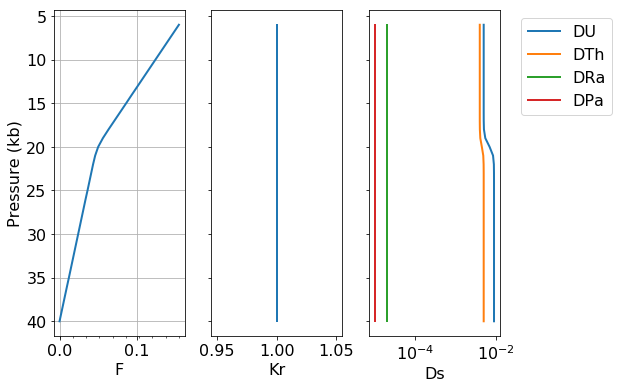

In [16]:
plot_inputs(df)

In [17]:
df

,P,F,Kr,DU,DTh,DRa,DPa
0,40.0,0.00000,1.0,0.00900,0.00500,0.00002,0.00001
1,39.0,0.00241,1.0,0.00900,0.00500,0.00002,0.00001
2,38.0,0.00482,1.0,0.00900,0.00500,0.00002,0.00001
3,37.0,0.00723,1.0,0.00900,0.00500,0.00002,0.00001
4,36.0,0.00964,1.0,0.00900,0.00500,0.00002,0.00001
5,35.0,0.01210,1.0,0.00900,0.00500,0.00002,0.00001
6,34.0,0.01450,1.0,0.00900,0.00500,0.00002,0.00001
7,33.0,0.01690,1.0,0.00900,0.00500,0.00002,0.00001
8,32.0,0.01930,1.0,0.00900,0.00500,0.00002,0.00001
9,31.0,0.02170,1.0,0.00900,0.00500,0.00002,0.00001


### Solve the 1-D column problem

In [18]:
# initialze the solver object
us = DynMelt(df)

# set column parameters for initial model run
phi0 = 0.001
W0 = 1. # cm/yr
n = 2.

df_out = us.solve_all_1D(phi0,n,W0)

TypeError: solve_all_1D() missing 1 required positional argument: 'F'

## Activities at the top of the column

In [ ]:
df_out[['(230Th/238U)','(226Ra/230Th)','(231Pa/235U)']].iloc[-1]

## Plot solution

In [ ]:
plot_1Dcolumn(df_out)
plt.show()

## View the dataframe

In [ ]:
df_out

## Calculated gridded activity ratios at the top of the column

In [ ]:
# set phi and W values for grid calculation:
#Use to create evenly spaced phi and W grid in logspace:
#phi0 = np.logspace(-4,-2,11)
#W0 = np.logspace(-1,2,11)

#Use to set specific phi and W values (cm/yr.) for grid:
phi0 = np.array([0.001, 0.002, 0.005, 0.01])
W0 = np.array([0.5, 1., 2., 5., 10., 20., 50.])

act = us.solve_grid(phi0, n, W0, us.D_238, us.lambdas_238 )

In [ ]:
Th = act[0]
Ra = act[1]

df = pd.DataFrame(Th)
df.to_csv("Th_grid_{}.csv".format(runname))
df = pd.DataFrame(Ra)
df.to_csv("Ra_grid_{}.csv".format(runname))

In [ ]:
act_235 = us.solve_grid(phi0, n, W0, us.D_235, us.lambdas_235 )
Pa = act_235[0]
df = pd.DataFrame(Pa)
df.to_csv("Pa_grid_{}.csv".format(runname))

In [ ]:
plot_mesh_Ra(Th,Ra,figsize=(8,8))

In [ ]:
plot_mesh_Pa(Th,Pa,figsize=(8,8))